In [35]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, AffinityPropagation
from scipy.cluster.hierarchy import dendrogram

import dist_util as util

random_state = 4012

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/davidsule/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
entities_orig = "academicjournal album algorithm astronomicalobject award band book chemicalcompound chemicalelement conference country discipline election enzyme event field literarygenre location magazine metrics misc musicalartist musicalinstrument musicgenre organisation person poem politicalparty politician product programlang protein researcher scientist song task theory university writer"
entities_orig = entities_orig.split()
# Manual Correction
substitute = {"musicalartist": "musician", "organisation": "organization", "politicalparty": "party", "academicjournal": "journal", "chemicalcompound": "chemical", "chemicalelement": "chemical", "astronomicalobject": "galaxy", "musicgenre": "genre", "literarygenre": "genre", "programlang": "java", "musicalinstrument": "instrument", "misc": "miscellaneous"}
entities = set()
for entity in entities_orig:
    if entity in substitute:
        entities.add(substitute[entity])
    else:
        entities.add(entity)

entities = list(entities)
entities.sort()
print(entities)

['album', 'algorithm', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'galaxy', 'genre', 'instrument', 'java', 'journal', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'organization', 'party', 'person', 'poem', 'politician', 'product', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']


In [3]:
# Get categories with most frequent word meanings
# util.category_dict(most_frequent_synset(entities), 2, entities)

In [4]:
# Check meanings and definitions for manual correction
idx = 36
synlist = wordnet.synsets(entities[idx])
print(idx, entities[idx])
for i, syn in enumerate(synlist):
    print(i, syn, syn.definition())

36 writer
0 Synset('writer.n.01') writes (books or stories or articles or the like) professionally (for pay)
1 Synset('writer.n.02') a person who is able to write and has written something


In [5]:
# Manual corrections of meanings. Key: idx in Entity_labels, value: idx of meaning in wordnet.synsets(word)
# check: To check whether entities are the same as the list the meaning dict was made on
check = ['album', 'algorithm', 'award', 'band', 'book', 'chemical', 'conference', 'country', 'discipline', 'election', 'enzyme', 'event', 'field', 'galaxy', 'genre', 'instrument', 'java', 'journal', 'location', 'magazine', 'metrics', 'miscellaneous', 'musician', 'organization', 'party', 'person', 'poem', 'politician', 'product', 'protein', 'researcher', 'scientist', 'song', 'task', 'theory', 'university', 'writer']
if entities != check:
    raise ValueError("entities modified since meaning_dict was edited!")
meaning_dict = {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 3, 13: 2, 14: 0, 15: 5, 16: 2, 17: 1, 18: 0, 19: 0, 20: 3, 21: 0, 22: 0, 23: 2, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 1, 34: 0, 35: 2, 36: 0}

In [18]:
# Get categories with associated words
entity_syns = []
for i, word in enumerate(entities):
    entity_syns.append(wordnet.synsets(word)[meaning_dict[i]])
tree_categories = util.category_dict(entity_syns, 2, entities)
for category, entity in tree_categories.items():
    print(f"{category}:\t{entity}")

Synset('object.n.01'):	['album', 'book', 'instrument', 'journal', 'location', 'magazine', 'product']
Synset('psychological_feature.n.01'):	['algorithm', 'discipline', 'election', 'event', 'field', 'genre', 'task', 'theory']
Synset('communication.n.02'):	['award', 'java', 'poem', 'song']
Synset('group.n.01'):	['band', 'conference', 'country', 'galaxy', 'organization', 'party', 'university']
Synset('matter.n.03'):	['chemical', 'enzyme']
Synset('measure.n.02'):	['metrics']
Synset('assorted.s.01'):	['miscellaneous']
Synset('causal_agent.n.01'):	['musician', 'person', 'politician', 'researcher', 'scientist', 'writer']
Synset('thing.n.12'):	['protein']


In [8]:
# Calculate Wu-Palmer Similarities
similarities = util.get_wup_sim(entity_syns)
distances = 1 - similarities

In [50]:
# K-MEDOIDS
init_method = "heuristic" # heuristic / k-medoids++
km = KMedoids(n_clusters=7, metric="precomputed", method="pam", init=init_method, random_state=random_state)
km = km.fit_predict(distances)
km_distance_categories = util.get_categories(km, entities)
for category, entity in km_distance_categories.items():
    print(f"{category}:\t{entity}")

2:	['album', 'book', 'instrument', 'journal', 'magazine', 'product']
1:	['algorithm', 'election', 'event', 'metrics', 'miscellaneous', 'task']
3:	['award', 'java', 'poem', 'song']
5:	['band', 'conference', 'country', 'galaxy', 'organization', 'party', 'university']
0:	['chemical', 'enzyme', 'protein']
6:	['discipline', 'field', 'genre', 'theory']
4:	['location', 'musician', 'person', 'politician', 'researcher', 'scientist', 'writer']


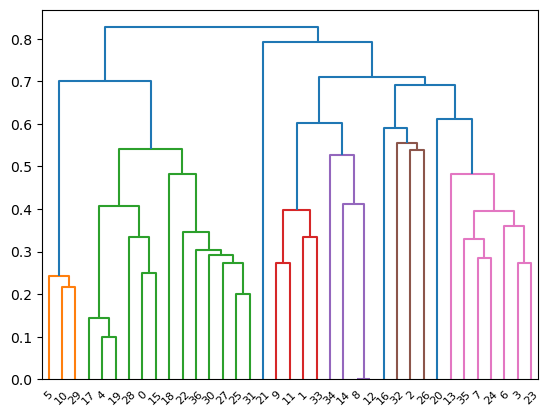

In [47]:
# AGGLOMERATIVE CLUSTERING
linkage = "average" # "complete" / "average" / "single"
ac = AgglomerativeClustering(n_clusters=None, metric="precomputed", compute_full_tree=True, linkage=linkage, distance_threshold=0)

# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

ac = ac.fit(distances)
plot_dendrogram(ac, truncate_mode="level", p=8)

In [70]:
# AGGLOMERATIVE CLUSTERING
linkage = "average" # "complete" / "average" / "single"
ac = AgglomerativeClustering(n_clusters=7, metric="precomputed", compute_full_tree=True, linkage=linkage)
ac = ac.fit_predict(distances)
ac_distance_categories = util.get_categories(ac, entities)
for category, entity in ac_distance_categories.items():
    print(f"{category}:\t{entity}")

1:	['album', 'book', 'instrument', 'journal', 'location', 'magazine', 'musician', 'person', 'politician', 'product', 'researcher', 'scientist', 'writer']
0:	['algorithm', 'discipline', 'election', 'event', 'field', 'genre', 'task', 'theory']
2:	['award', 'java', 'poem', 'song']
3:	['band', 'conference', 'country', 'galaxy', 'organization', 'party', 'university']
4:	['chemical', 'enzyme', 'protein']
6:	['metrics']
5:	['miscellaneous']


In [82]:
# Affinity Propagation
damping = 0.5 # [0.5, 1.0)
ap = AffinityPropagation(damping=damping, affinity="precomputed", random_state=random_state)
ap = ap.fit_predict(similarities)
ap_distance_categories = util.get_categories(ap, entities)
for category, entity in ap_distance_categories.items():
    print(f"{category}:\t{entity}")

2:	['album', 'book', 'instrument', 'journal', 'magazine', 'product']
1:	['algorithm', 'discipline', 'election', 'event', 'field', 'genre', 'metrics', 'miscellaneous', 'task', 'theory']
0:	['award', 'java', 'poem', 'song']
3:	['band', 'conference', 'country', 'galaxy', 'organization', 'party', 'university']
5:	['chemical', 'enzyme', 'protein']
4:	['location', 'musician', 'person', 'politician', 'researcher', 'scientist', 'writer']


In [91]:
# Spectral Clustering
assign_labels = "cluster_qr" # "kmeans", "discretize", "cluster_qr"
sc = SpectralClustering(n_clusters=6, random_state=random_state, affinity="precomputed", assign_labels=assign_labels)
sc = sc.fit_predict(similarities)
sc_distance_categories = util.get_categories(sc, entities)
for category, entity in sc_distance_categories.items():
    print(f"{category}:\t{entity}")

1:	['album', 'book', 'instrument', 'journal', 'magazine', 'product']
3:	['algorithm', 'discipline', 'election', 'event', 'field', 'genre', 'task', 'theory']
2:	['award', 'java', 'metrics', 'miscellaneous', 'poem', 'song']
4:	['band', 'conference', 'country', 'galaxy', 'organization', 'party', 'university']
0:	['chemical', 'enzyme', 'protein']
5:	['location', 'musician', 'person', 'politician', 'researcher', 'scientist', 'writer']
